In [50]:
from typing import List, TypedDict
from langgraph.graph import StateGraph,START,END
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import os
import json
import requests
import base64

In [51]:
"""Podłączenie do API OpenAI """
load_dotenv() 
chat_llm = ChatOpenAI(model="gpt-4o") 

In [ ]:
class AgentState(TypedDict):
    messages: List[HumanMessage]
    intent: str
    odpowiedz: str
    recipe: dict
    image: str
 
"""Prompt dla identyfikacji żądania uzytkownika"""
SYSTEM_PROMPT = (
    """Jesteśmy asystentem kulinarnym, który pomaga użytkownikom znaleźć przepisy na podstawie ich preferencji."""
    """Na podstawie ostatniej wiadomości użytkownika, zidentyfikuj intencję jako 'recipe' jeśli użytkownik pyta o przepis lub 'chat' jeśli chce po prostu porozmawiać lub to jest żądanie na wygerowanie PRZEPISU NA PODSTAWIE zdjęcia"""
    """Na tego co zweryfikujesz zwróć intencję w polu 'intent' w formacie JSON, np. {"intent": "recipe"} lub {"intent": "chat"} lub {"intent": "recipe_from_image"}"""
     
     
 )


"""recepte"""
RECIPE_PROMPT = """Jesteś asystentem kulinarnym. Podaj szczegółowy przepis kulinarny w formacie JSON, formatowanie w taki sposób jest badzo ważne, ponieważ będzie on parsowany przez program. Odpowiedź powinna zawierać nazwę potrawy, listę składników, instrukcję krok po kroku oraz czas przygotowania. Oto przykładowy format odpowiedzi:
{
  "name": "nazwa potrawy",
  "ingredients": ["składnik 1", "składnik 2"],
  "steps": ["krok 1", "krok 2"],
  "time": "czas przygotowania"
}
Odpowiadaj TYLKO w formacie JSON, bez dodatkowego tekstu.

"""


"""do rozmowy"""
CHAT_PROMPT = """Jesteś przyjaznym asystentem kulinarnym. Rozmawiaj naturalnie z użytkownikiem po polsku.
Odpowiedz powinna byc ładnie sformatowana i zwięzła, ale nie musi być w formacie JSON.
Piszesz jesli pytanie nie związane z gotowaniem o tym że jesteś asystentem kulinarnym i nie możesz odpowiedzieć na takie pytania."""



def detect_intent(state: AgentState) -> AgentState:
    last_message = state["messages"][-1].content
    print(f"DEBUG detect_intent - wiadomość: {last_message}")

    response = chat_llm.invoke([
        SystemMessage(content=SYSTEM_PROMPT),
        HumanMessage(content=last_message)
    ])
    print(f"DEBUG detect_intent - odpowiedź LLM: {response.content}")

    try:
        parsed = json.loads(response.content)
        intent = parsed.get("intent", "chat")
    except:
        intent = "chat"

    print(f"DEBUG detect_intent - intent: {intent}")
    return {**state, "intent": intent}


def router(state: AgentState) -> str:
    """Routing do odpowiednich funkcji na podstawie intencji"""
    if state["intent"] == "recipe" or state["intent"] == "chat":
        return "chat_node"
    elif state["intent"] == "recipe_from_image":
        return "image_to_recipe"



def chat_node(state: AgentState):
    if state["intent"] == "recipe":
        system_prompt = RECIPE_PROMPT
    else:
        system_prompt = CHAT_PROMPT

    messages = [
        SystemMessage(content=system_prompt),
        *state["messages"]
    ]

    response = chat_llm.invoke(messages)

    if state["intent"] == "recipe":
        try:
            result = json.loads(response.content)
        except json.JSONDecodeError:
            result = {"raw": response.content}
        with open("recipe.json", "w", encoding="utf-8") as f:
            json.dump(result, f, ensure_ascii=False, indent=2)

        return {**state, "recipe": result}

    else:
        return {**state, "odpowiedz": response.content}


def image_to_recipe(state: AgentState) -> AgentState:
    
    filename = state.get("filename", "dish.jpg")  
    
    image_path = os.path.join("zdjęcia", filename)
    
    if not os.path.exists(image_path):
        return {**state, "odpowiedz": "Plik nie został znaleziony w folderze zdjęcia."}

    with open(image_path, "rb") as f:
        image_data = base64.b64encode(f.read()).decode("utf-8")
    
    msg = HumanMessage(content=[
        {
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": "image/jpeg",
                "data": image_data,
            }
        },
        {
            "type": "text",
            "text": "Wygeneruj szczegółowy przepis na to danie. Podaj składniki i instrukcję krok po kroku."
        }
    ])

    response = chat_llm.invoke([msg])
    
    return {**state, "recipe": response.content}

In [53]:
graph = StateGraph(AgentState)
graph.add_node("detect_intent", detect_intent)
graph.add_node("chat_node", chat_node)
graph.add_node("image_to_recipe", image_to_recipe)

 

graph.add_edge(START, "detect_intent")


graph.set_entry_point("detect_intent")
graph.add_conditional_edges(
    "detect_intent",
    router,          
    {

        "image_to_recipe": "image_to_recipe",
        "chat_node": "chat_node",
    }
)

graph.add_edge("chat_node", END)
graph.add_edge("image_to_recipe", END)


app = graph.compile()


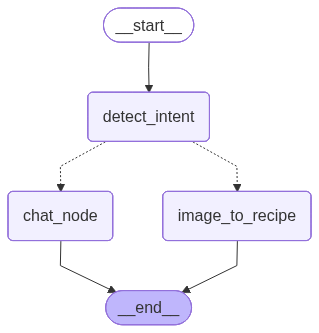

In [54]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [55]:


result = app.invoke({
    "messages": [HumanMessage(content="Podaj receptę tiramisu")],
    "intent": "",
    "odpowiedz": "",
    "recipe": {},
    "image": ""
})
print("Wynik:", result.get('odpowiedz') or result.get('recipe') or result['messages'][-1].content)

DEBUG detect_intent - wiadomość: Podaj receptę tiramisu
DEBUG detect_intent - odpowiedź LLM: {"intent": "recipe"}
DEBUG detect_intent - intent: recipe
Wynik: {'name': 'Tiramisu', 'ingredients': ['500 g mascarpone', '4 żółtka', '100 g cukru', '200 ml espresso', '2 łyżki likieru amaretto', '300 g biszkoptów (ladyfingers)', '2 łyżki kakao'], 'steps': ['Przygotuj espresso i wymieszaj je z likierem amaretto. Pozostaw do ostygnięcia.', 'W misce ubij żółtka z cukrem aż masa stanie się jasna i puszysta.', 'Dodaj mascarpone do ubitych żółtek z cukrem i delikatnie wymieszaj do uzyskania gładkiej masy.', 'Zanurz każde z biszkoptów w schłodzonym espresso z amaretto na kilka sekund.', 'Układaj namoczone biszkopty na dnie prostokątnego naczynia, tworząc pierwszą warstwę.', 'Na warstwę biszkoptów nałóż połowę masy mascarpone i równomiernie rozsmaruj.', 'Powtórz proces namaczania biszkoptów i ułóż drugą warstwę na masie mascarpone.', 'Nałóż pozostałą masę mascarpone na drugą warstwę biszkoptów.', 'Prz

In [56]:

result = app.invoke({
    "messages": [HumanMessage(content="Jaki stroj kucharza?")],
    "intent": "",
    "odpowiedz": "",
    "recipe": {},
    "image": ""
})
print("Wynik:", result.get('odpowiedz') or result.get('recipe') or result['messages'][-1].content)

DEBUG detect_intent - wiadomość: Jaki stroj kucharza?
DEBUG detect_intent - odpowiedź LLM: {"intent": "chat"}
DEBUG detect_intent - intent: chat
Wynik: Strój kucharza jest jednocześnie funkcjonalny i tradycyjny, a jego podstawowe elementy to:

1. **Czapka kucharska (toque)** – Symbolizuje czystość i status w kuchni. Tradycyjnie wyższa czapka oznacza większe doświadczenie.

2. **Bluza kucharska** – Zwykle biała, dwurzędowa z guziki, zapewniająca ochronę przed ciepłem i łatwa do utrzymania w czystości.

3. **Fartuch** – Chroni ubranie kucharza przed plamami i zabrudzeniami.

4. **Spodnie kucharskie** – Czarno-białe szachownice są tradycyjnym wzorem, które pomagają ukrywać plamy.

5. **Buty kucharskie** – Antypoślizgowe, wygodne i z zakrytymi palcami, aby zapewnić bezpieczeństwo w kuchni.

6. **Ściereczka** – Najczęściej przewieszona przez pasek fartucha, używana do wycierania rąk i czyszczenia powierzchni roboczych.

Noszenie odpowiedniego stroju nie tylko chroni kucharza, ale także wpły

In [57]:

result = app.invoke({
    "messages": [HumanMessage(content="Podaj receptę na postawie zdjęcia")],
    "intent": "",
    "odpowiedz": "",
    "recipe": {},
    "image": ""
})
print("Wynik:", result.get('odpowiedz') or result.get('recipe') or result['messages'][-1].content)

DEBUG detect_intent - wiadomość: Podaj receptę na postawie zdjęcia
DEBUG detect_intent - odpowiedź LLM: {"intent": "recipe_from_image"}
DEBUG detect_intent - intent: recipe_from_image
Wynik: ### Kanapka z grillowanym kurczakiem

#### Składniki:

- 2 bułki
- 2 piersi z kurczaka
- 2 małe pomidory, pokrojone w plastry
- Kilka liści sałaty
- Kilka plasterków korniszonów
- 1 łyżeczka czarnego pieprzu
- 1 łyżeczka soli czosnkowej
- 1 łyżeczka przyprawy do drobiu

#### Instrukcje:

1. **Przygotowanie mięsa:**
   - Umyj i osusz piersi z kurczaka.
   - Wymieszaj sól czosnkową, pieprz i przyprawę do drobiu, a następnie natrzyj tą mieszanką piersi z kurczaka.

2. **Grillowanie kurczaka:**
   - Rozgrzej grill (możesz również użyć patelni grillowej).
   - Grilluj piersi z kurczaka na średnim ogniu przez około 6-7 minut z każdej strony, aż będą całkowicie ugotowane i złociste.

3. **Przygotowanie dodatków:**
   - W międzyczasie przygotuj resztę składników: pokrój pomidory, przygotuj liście sałaty i 

In [58]:
result = app.invoke({
    "messages": [HumanMessage(content="Jaki jest nowy perfum Chanel?")],
    "intent": "",
    "odpowiedz": "",
    "recipe": {},
    "image": ""
})
print("Wynik:", result.get('odpowiedz') or result.get('recipe') or result['messages'][-1].content)

DEBUG detect_intent - wiadomość: Jaki jest nowy perfum Chanel?
DEBUG detect_intent - odpowiedź LLM: {"intent": "chat"}
DEBUG detect_intent - intent: chat
Wynik: Jestem asystentem kulinarnym, więc specjalizuję się w gotowaniu i tematach kulinarnych. Niestety, nie posiadam informacji na temat nowych perfum Chanel. Jeśli masz pytania dotyczące gotowania, chętnie pomogę!
